In [1]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [2]:
for dirname, _, filenames in os.walk('../../data'):
    for filename in filenames:
        print(os.path.join(dirname, filename).replace('\\','/'))

../../data/clean-twitter_en.csv
../../data/clean_kaggle.csv
../../data/clean_public.csv
../../data/cyberbullying_tweets.csv
../../data/hate_speech.csv
../../data/labeled_tweets.csv
../../data/NAACL_SRW_2016.csv
../../data/public_data_labeled.csv
../../data/twitter_en.csv


In [10]:
df = pd.read_csv('../../data/hate_speech.csv',index_col=0)
df.head()

,id,location,follower_count,friends_count,retweet_count,favorite_count,text,word_length,label
0,930620467,NaN,19820,258,19,17,elliot rodger killed one woman rejected date w...,11,0
1,13857342,"Portland, OR",19172,797,0,2,keep mind volume volume vitriol disproportiona...,8,0
2,482583016,NaN,59,39,0,3,face every time hear see kat hope get stuck mkr,10,0
3,930620467,NaN,19820,258,1,0,empathy social skill informs others specie wit...,11,0
4,13857342,"Portland, OR",19170,797,0,1,yo going bsdcan going could cause trouble p,8,0


In [11]:
df = df[~df['text'].isnull()]

In [12]:
df.shape

(1229, 9)

In [13]:
# the location variable is too dirty in the first place, I assume it is less useful in the current state and drop it out first.
df.drop('location',axis=1,inplace=True)

In [14]:
# transfer the raw text data into matrix
cv = CountVectorizer(analyzer='word',min_df=0.001)
content  = df.text
vector = cv.fit_transform(content)
data = vector.toarray()
index_name = cv.get_feature_names_out()
tfidf = TfidfTransformer()
x_tf = tfidf.fit_transform(vector)

In [15]:
# train and test
X_train, X_test, y_train, y_test = train_test_split(x_tf, df['label'], test_size=0.2, stratify=df['label'], random_state=42)

In [16]:
clf = MultinomialNB()
clf.fit(X_train,y_train)
y_pre = clf.predict(X_test)
accuracy_score(y_test,y_pre)

0.8252032520325203

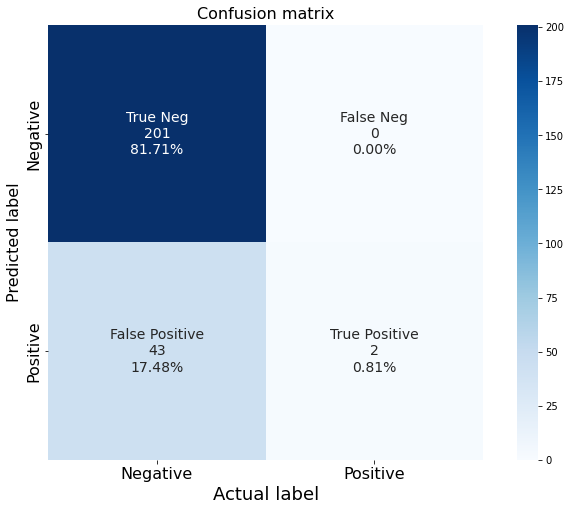

In [17]:
#confusion matrix
from matplotlib.pyplot import xticks
from sklearn.metrics import confusion_matrix
fig,ax = plt.subplots(figsize=(12,8))
mx = confusion_matrix(y_test,y_pre)
# cmd = ConfusionMatrixDisplay(mx,display_labels=['Positive','Negative'])
group_names = ['True Neg','False Neg','False Positive','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in
                mx.flatten()]
group_percentages = ["{:.2%}".format(value) for value in mx.flatten()/np.sum(mx) ]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.array(labels).reshape(2,2)
sns.heatmap(data=mx,annot=labels,fmt='',cmap='Blues',square=True,annot_kws={"fontsize":14})
ax.set_title('Confusion matrix',fontsize=16)
plt.xlabel('Actual label',fontsize=18)
plt.ylabel('Predicted label',fontsize=16)
ax.set_xticklabels(['Negative','Positive'],fontsize=16)
ax.set_yticklabels(['Negative','Positive'],fontsize=16)
plt.savefig('./confusion_matrix.png')

In [27]:
train_sizes=np.linspace(0.1, 1.0, 5)
train_sizes, train_scores, test_scores = learning_curve(
        estimator=MultinomialNB(),
        X=x_tf,
        y=df['label'],
        scoring='accuracy',
        cv=5,
        n_jobs=1,
        train_sizes=train_sizes,
        return_times=True,
    )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
# fit_times_mean = np.mean(fit_times, axis=1)
# fit_times_std = np.std(fit_times, axis=1)# Plot learning curve

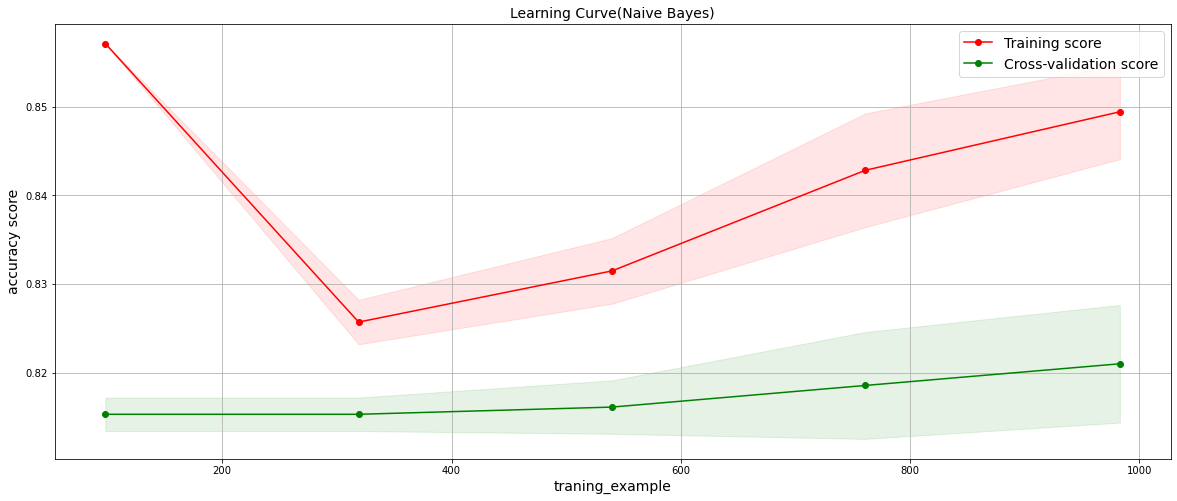

In [34]:
# learning curve
from sklearn.model_selection import learning_curve
fig,ax = plt.subplots(figsize=(20,8))

ax.grid()
ax.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
ax.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)
ax.plot(
    train_sizes, train_scores_mean, "o-", color="r", label="Training score"
)
ax.plot(
    train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
)
FS = 14
ax.legend(loc="best",fontsize=FS)
ax.set_title('Learning Curve(Naive Bayes)',fontsize=FS)
ax.set_xlabel('traning_example',fontsize=FS)
ax.set_ylabel('accuracy score',fontsize=FS)
plt.show()

1. This learning curve indicates us that the model is under-fitting, and we require more training size. Since as the training_example increases, the training_score constantly increase and do not halt at a certain point.
2. The model shows large error in both variance and bias, because the gap between the two curves is large and need to be narrowed.

In [44]:
y_test.value_counts()

0    201
1     45
Name: label, dtype: int64

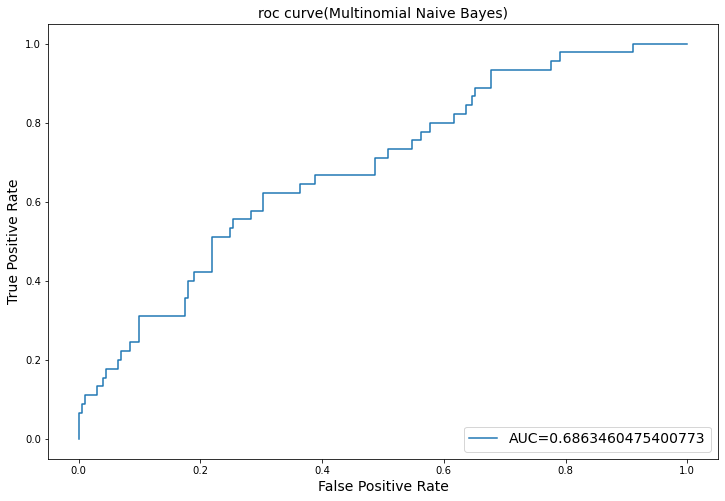

In [55]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
plt.figure(figsize=(12,8))
y_pred_prob = clf.predict_proba(X_test)[::,1]
fpr, tpr, threshold = roc_curve(y_test,y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.title('roc curve(Multinomial Naive Bayes)',fontsize=FS)
plt.ylabel('True Positive Rate',fontsize=FS)
plt.xlabel('False Positive Rate',fontsize=FS)
plt.legend(loc='lower right',fontsize=FS)
plt.show()

1. AUC is a metric that utilizes probabilities of the class predictions, we can be more confident in a model that has a higher AUC score than one with a lower score even if they have similar accuracies.
2. In  this model, the Auc score is not pretty high, which means that the model only does a fair job in classification